<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/ML_SHAP_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/datadigger01/AI-Trade/main/Data/coffee_future_price.csv"
response = requests.get(url)

# Save the content to a temporary file
with open("price_data.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file into a pandas DataFrame, skipping the first two rows
df = pd.read_csv("price_data.csv")

# Display the first few rows of the DataFrame
display(df.head())

,Date,Close_Price,High_Price,Low,Open,Volume
0,2020-11-05,105.949997,106.800003,103.550003,103.900002,29467
1,2020-11-06,106.949997,108.000000,105.949997,106.550003,18754
2,2020-11-09,106.849998,109.349998,106.349998,107.349998,26289
3,2020-11-10,107.300003,107.650002,105.349998,106.750000,28673
4,2020-11-11,109.099998,110.550003,107.800003,108.000000,25497


### SHAP 분석을 위한 Feature 생성

In [2]:
"""
커피 가격 예측을 위한 Feature Engineering 함수 모듈

사용 예시:
    df = pd.read_csv('price_data.csv')
    df_with_features = create_all_features(df)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def create_lag_features(df, price_cols=['Close_Price', 'Open', 'High_Price', 'Low'],
                       close_lags=[1, 2, 3, 5, 7, 14, 21, 30],
                       other_lags=[1, 2, 3, 5]):
    """
    과거 가격 정보 Lag Features 생성

    Args:
        df: 원본 데이터프레임
        price_cols: lag를 생성할 컬럼들
        close_lags: Close Price에 대한 lag 기간
        other_lags: 다른 가격들에 대한 lag 기간

    Returns:
        lag feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Close Price Lags
    for lag in close_lags:
        df[f'close_lag_{lag}'] = df['Close_Price'].shift(lag)

    # Open, High, Low Lags
    for lag in other_lags:
        df[f'open_lag_{lag}'] = df['Open'].shift(lag)
        df[f'high_lag_{lag}'] = df['High_Price'].shift(lag)
        df[f'low_lag_{lag}'] = df['Low'].shift(lag)

    return df


def create_return_features(df, periods=[2, 3, 5, 7, 14]):
    """
    가격 변화율 및 수익률 Features 생성

    Args:
        df: 원본 데이터프레임
        periods: 수익률 계산 기간

    Returns:
        return feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Daily Returns
    df['daily_return'] = df['Close_Price'].pct_change(1)
    df['daily_return_lag1'] = df['daily_return'].shift(1)

    # Multi-period Returns
    for period in periods:
        df[f'return_{period}d'] = df['Close_Price'].pct_change(period).shift(1)

    # Price Changes
    df['price_change_1d'] = (df['Close_Price'] - df['Close_Price'].shift(1)).shift(1)
    df['price_change_5d'] = (df['Close_Price'] - df['Close_Price'].shift(5)).shift(1)

    return df


def create_moving_average_features(df, sma_windows=[5, 10, 20, 50],
                                   ema_windows=[5, 10, 20]):
    """
    이동평균 Features 생성

    Args:
        df: 원본 데이터프레임
        sma_windows: 단순이동평균 윈도우 크기
        ema_windows: 지수이동평균 윈도우 크기

    Returns:
        이동평균 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Simple Moving Averages
    for window in sma_windows:
        df[f'sma_{window}'] = df['Close_Price'].rolling(window=window).mean().shift(1)

    # Exponential Moving Averages
    for window in ema_windows:
        df[f'ema_{window}'] = df['Close_Price'].ewm(span=window, adjust=False).mean().shift(1)

    # MA Crossover Features
    df['sma_5_10_diff'] = (df['sma_5'] - df['sma_10'])
    df['sma_10_20_diff'] = (df['sma_10'] - df['sma_20'])
    df['sma_20_50_diff'] = (df['sma_20'] - df['sma_50'])

    # Price relative to MAs
    df['price_to_sma_5'] = (df['Close_Price'] / df['sma_5'].shift(-1)) - 1
    df['price_to_sma_20'] = (df['Close_Price'] / df['sma_20'].shift(-1)) - 1
    df['price_to_sma_50'] = (df['Close_Price'] / df['sma_50'].shift(-1)) - 1

    return df


def create_volatility_features(df, windows=[5, 10, 20], atr_period=14):
    """
    변동성 Features 생성

    Args:
        df: 원본 데이터프레임
        windows: 변동성 계산 윈도우
        atr_period: ATR 계산 기간

    Returns:
        변동성 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Standard Deviation
    daily_return = df['Close_Price'].pct_change(1)
    for window in windows:
        df[f'volatility_{window}d'] = daily_return.rolling(window=window).std().shift(1)

    # High-Low Range
    df['hl_range'] = ((df['High_Price'] - df['Low']) / df['Low']).shift(1)
    df['hl_range_5d_avg'] = df['hl_range'].shift(-1).rolling(window=5).mean().shift(1)

    # ATR (Average True Range)
    df['tr'] = df[['High_Price', 'Close_Price']].max(axis=1) - df[['Low', 'Close_Price']].min(axis=1)
    df['atr_14'] = df['tr'].rolling(window=atr_period).mean().shift(1)

    return df


def create_momentum_features(df, rsi_periods=[7, 14]):
    """
    모멘텀 지표 Features 생성 (RSI, MACD)

    Args:
        df: 원본 데이터프레임
        rsi_periods: RSI 계산 기간

    Returns:
        모멘텀 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    for period in rsi_periods:
        df[f'rsi_{period}'] = calculate_rsi(df['Close_Price'], period).shift(1)

    # MACD
    ema_12 = df['Close_Price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close_Price'].ewm(span=26, adjust=False).mean()
    df['macd'] = (ema_12 - ema_26).shift(1)
    df['macd_signal'] = df['macd'].shift(-1).ewm(span=9, adjust=False).mean().shift(1)
    df['macd_histogram'] = (df['macd'] - df['macd_signal'])

    # Momentum
    df['momentum_5'] = (df['Close_Price'] / df['Close_Price'].shift(5) - 1).shift(1)
    df['momentum_10'] = (df['Close_Price'] / df['Close_Price'].shift(10) - 1).shift(1)

    return df


def create_bollinger_bands(df, window=20, num_std=2):
    """
    볼린저 밴드 Features 생성

    Args:
        df: 원본 데이터프레임
        window: 이동평균 윈도우
        num_std: 표준편차 배수

    Returns:
        볼린저 밴드 feature가 추가된 데이터프레임
    """
    df = df.copy()

    sma_20 = df['Close_Price'].rolling(window=window).mean()
    std_20 = df['Close_Price'].rolling(window=window).std()

    df['bb_upper'] = (sma_20 + (std_20 * num_std)).shift(1)
    df['bb_middle'] = sma_20.shift(1)
    df['bb_lower'] = (sma_20 - (std_20 * num_std)).shift(1)
    df['bb_width'] = ((df['bb_upper'] - df['bb_lower']) / df['bb_middle'])
    df['bb_position'] = ((df['Close_Price'] - df['bb_lower'].shift(-1)) /
                          (df['bb_upper'].shift(-1) - df['bb_lower'].shift(-1)))

    return df


def create_volume_features(df, volume_lags=[1, 2, 3, 5], sma_windows=[5, 20]):
    """
    거래량 Features 생성

    Args:
        df: 원본 데이터프레임
        volume_lags: 거래량 lag 기간
        sma_windows: 거래량 이동평균 윈도우

    Returns:
        거래량 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Volume Lags
    for lag in volume_lags:
        df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)

    # Volume Moving Averages
    for window in sma_windows:
        df[f'volume_sma_{window}'] = df['Volume'].rolling(window=window).mean().shift(1)

    # Volume Ratio
    df['volume_ratio'] = (df['Volume'] / df['volume_sma_20'].shift(-1)).shift(1)

    # Price-Volume Trend
    df['price_volume_trend'] = ((df['Close_Price'] - df['Close_Price'].shift(1)) /
                                 df['Close_Price'].shift(1) * df['Volume']).shift(1)

    return df


def create_price_pattern_features(df):
    """
    가격 패턴 Features 생성

    Args:
        df: 원본 데이터프레임

    Returns:
        가격 패턴 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Intraday Range
    df['intraday_range'] = ((df['High_Price'] - df['Low']) / df['Open']).shift(1)

    # Open-Close Relationship
    df['open_close_diff'] = ((df['Close_Price'] - df['Open']) / df['Open']).shift(1)
    df['is_bullish'] = (df['Close_Price'] > df['Open']).astype(int).shift(1)

    # Gap
    df['gap'] = ((df['Open'] - df['Close_Price'].shift(1)) / df['Close_Price'].shift(1)).shift(1)

    # High/Low relative to Close
    df['high_to_close'] = ((df['High_Price'] - df['Close_Price']) / df['Close_Price']).shift(1)
    df['low_to_close'] = ((df['Close_Price'] - df['Low']) / df['Close_Price']).shift(1)

    return df


def create_time_features(df):
    """
    시간 기반 Features 생성

    Args:
        df: 원본 데이터프레임 (Date 컬럼 필수)

    Returns:
        시간 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 기본 시간 특성
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df


def create_statistical_features(df, window=20):
    """
    통계적 Features 생성

    Args:
        df: 원본 데이터프레임
        window: rolling 윈도우 크기

    Returns:
        통계 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Min/Max
    df['rolling_max_20'] = df['Close_Price'].rolling(window=window).max().shift(1)
    df['rolling_min_20'] = df['Close_Price'].rolling(window=window).min().shift(1)
    df['distance_from_max_20'] = ((df['rolling_max_20'] - df['Close_Price']) /
                                    df['rolling_max_20']).shift(-1)
    df['distance_from_min_20'] = ((df['Close_Price'] - df['rolling_min_20']) /
                                    df['rolling_min_20']).shift(-1)

    # Percentile Rank
    df['percentile_rank_20'] = df['Close_Price'].rolling(window=window).apply(
        lambda x: pd.Series(x).rank().iloc[-1] / len(x), raw=False
    ).shift(1)

    return df


def create_all_features(df, include_target=True, remove_nan=True):
    """
    모든 Feature를 한번에 생성하는 메인 함수

    Args:
        df: 원본 데이터프레임 (Date, Close_Price, High_Price, Low, Open, Volume 컬럼 필수)
        include_target: 타겟 변수 (다음날 종가) 포함 여부
        remove_nan: 결측치 제거 여부 (기본값: True)

    Returns:
        모든 feature가 추가된 데이터프레임

    Example:
        >>> df = pd.read_csv('price_data.csv')
        >>> df['Date'] = pd.to_datetime(df['Date'])
        >>> df = df.sort_values('Date').reset_index(drop=True)
        >>> df_with_features = create_all_features(df, remove_nan=True)
    """
    df = df.copy()

    # 날짜 정렬 확인
    if not df['Date'].is_monotonic_increasing:
        df = df.sort_values('Date').reset_index(drop=True)

    # 타겟 변수 생성
    if include_target:
        df['target_next_close'] = df['Close_Price'].shift(-1)

    print("Feature Engineering 시작...")

    # 1. Lag Features
    print("  [1/10] Lag Features 생성 중...")
    df = create_lag_features(df)

    # 2. Return Features
    print("  [2/10] Return Features 생성 중...")
    df = create_return_features(df)

    # 3. Moving Average Features
    print("  [3/10] Moving Average Features 생성 중...")
    df = create_moving_average_features(df)

    # 4. Volatility Features
    print("  [4/10] Volatility Features 생성 중...")
    df = create_volatility_features(df)

    # 5. Momentum Features
    print("  [5/10] Momentum Features 생성 중...")
    df = create_momentum_features(df)

    # 6. Bollinger Bands
    print("  [6/10] Bollinger Bands 생성 중...")
    df = create_bollinger_bands(df)

    # 7. Volume Features
    print("  [7/10] Volume Features 생성 중...")
    df = create_volume_features(df)

    # 8. Price Pattern Features
    print("  [8/10] Price Pattern Features 생성 중...")
    df = create_price_pattern_features(df)

    # 9. Time Features
    print("  [9/10] Time Features 생성 중...")
    df = create_time_features(df)

    # 10. Statistical Features
    print("  [10/10] Statistical Features 생성 중...")
    df = create_statistical_features(df)

    print("✅ Feature Engineering 완료!")

    # Feature 개수 출력
    original_cols = ['Date', 'Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    target_col = ['target_next_close'] if include_target else []
    feature_cols = [col for col in df.columns
                   if col not in original_cols and col not in target_col]

    print(f"\n생성된 Feature 수: {len(feature_cols)}")
    print(f"결측치 제거 전 데이터 크기: {len(df)}행")

    # 결측치 제거
    if remove_nan:
        nan_count_before = df.isnull().any(axis=1).sum()
        df = df.dropna().reset_index(drop=True)
        print(f"결측치가 있는 행 수: {nan_count_before}행")
        print(f"결측치 제거 후 데이터 크기: {len(df)}행 ✅")
    else:
        nan_count = df.isnull().any(axis=1).sum()
        print(f"결측치가 있는 행 수: {nan_count}행 (제거하지 않음)")

    return df


# 사용 예시
if __name__ == "__main__":
    # 데이터 로드
    # df = pd.read_csv('price_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])

    # Feature Engineering (결측치 자동 제거)
    df_with_features = create_all_features(df, include_target=True, remove_nan=True)

    # 저장
    output_path = '/content/coffee_features_clean.csv'
    df_with_features.to_csv(output_path, index=False)
#    print(f"\n💾 저장 완료: {output_path}")

    # 샘플 데이터 확인
    print("\n📊 샘플 데이터 (처음 5행):")
    print(df_with_features.head())

Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Return Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Bollinger Bands 생성 중...
  [7/10] Volume Features 생성 중...
  [8/10] Price Pattern Features 생성 중...
  [9/10] Time Features 생성 중...
  [10/10] Statistical Features 생성 중...
✅ Feature Engineering 완료!

생성된 Feature 수: 89
결측치 제거 전 데이터 크기: 1259행
결측치가 있는 행 수: 51행
결측치 제거 후 데이터 크기: 1208행 ✅

📊 샘플 데이터 (처음 5행):
        Date  Close_Price  High_Price         Low        Open  Volume  \
0 2021-01-20   125.199997  127.050003  123.400002  126.550003   19721   
1 2021-01-21   126.449997  127.300003  124.750000  125.800003   13904   
2 2021-01-22   124.050003  126.300003  122.849998  125.699997   18266   
3 2021-01-25   123.250000  124.949997  122.150002  123.000000   18318   
4 2021-01-26   124.500000  125.900002  123.250000  123.400002   16225   

   target_next_close  close_lag_1  close_lag_2  close_

## SHAP Analysis for Random Forest and GBM(Light GBM) model



SHAP Analysis - 실행 가능한 완전한 코드 (LightGBM 버전)

이 코드는 두 가지 예제를 제공합니다:
1. main_example_single_model(): 단일 모델 SHAP 분석
2. main_example_multistep(): Multi-step Direct LightGBM 모델 SHAP 분석

실행 방법:
1. 데이터를 로드하고 feature engineering 수행
2. 모델을 학습
3. 각 함수의 주석을 해제하고 실행

예제 1: 단일 RandomForest 모델 SHAP 분석

[1단계] 데이터 로드
--------------------------------------------------------------------------------

[2단계] Feature와 Target 분리
--------------------------------------------------------------------------------
✅ Feature 개수: 94
✅ 샘플 개수: 1208
✅ Train: 1087행
✅ Test: 121행

[3단계] RandomForest 모델 학습
--------------------------------------------------------------------------------
✅ 모델 학습 완료!
   MAE: $9.5731
   RMSE: $12.2629
   R²: 0.9080

[4단계] SHAP 분석
--------------------------------------------------------------------------------

완전한 SHAP 분석 파이프라인

SHAP Analysis - RANDOMFOREST

[1] SHAP Explainer 생성 중...
[2] SHAP 값 계산 중...
   테스트 샘플 수: 121


 95%|=================== | 115/121 [00:13<00:00]       

✅ SHAP 값 계산 완료!
   Shape: (121, 94)
   Base value (평균 예측): 211.6382

[분석 1] 전역 Feature Importance
--------------------------------------------------------------------------------

Top 20 Features:
       feature  importance
           Low   12.577739
   Close_Price   11.986331
   close_lag_1   10.260624
    High_Price    8.122623
          Open    7.643738
     low_lag_1    6.474399
    high_lag_1    6.090445
   close_lag_2    6.021469
        sma_50    5.811937
rolling_max_20    5.717092
         sma_5    5.195388
    open_lag_1    4.926362
         ema_5    4.819285
    high_lag_2    4.610565
        ema_10    4.604515
     low_lag_2    3.938820
    high_lag_3    3.773814
        ema_20    3.565422
   close_lag_3    3.546988
      bb_upper    3.498237

[분석 2] 주요 시각화
--------------------------------------------------------------------------------

[시각화] SHAP Summary Plot 생성 중...
✅ 저장 완료: shap_results_rf/summary_plot.png


<Figure size 640x480 with 0 Axes>

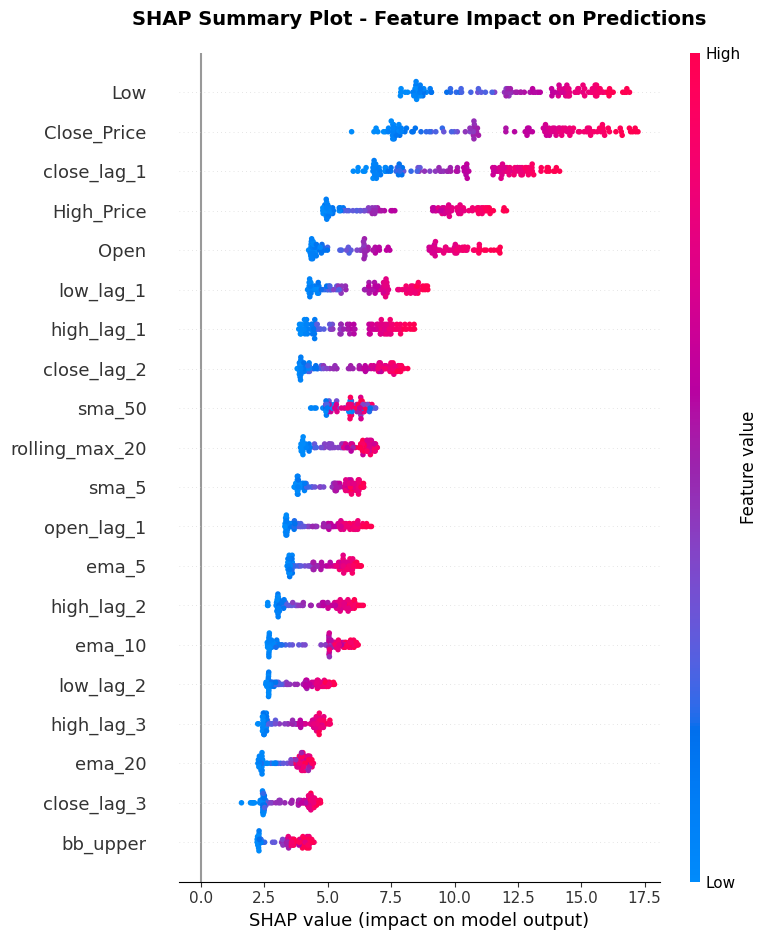


[시각화] SHAP Bar Plot (Top 20) 생성 중...
✅ 저장 완료: shap_results_rf/bar_plot.png


<Figure size 640x480 with 0 Axes>

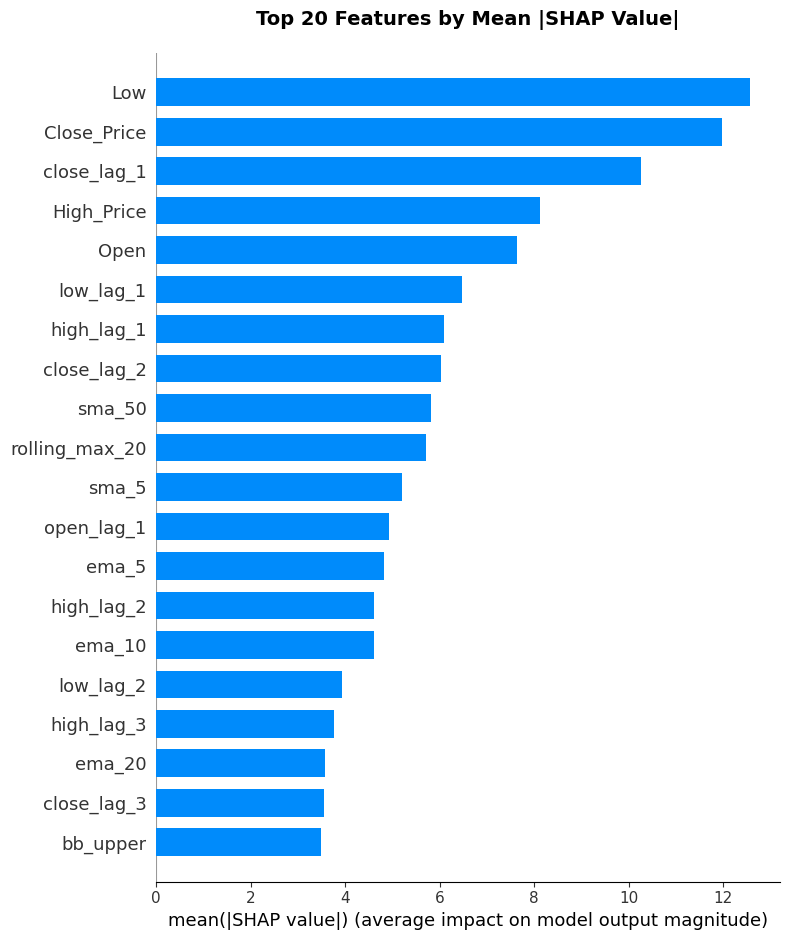


[시각화] SHAP Dependence Plot - Low 생성 중...
✅ 저장 완료: shap_results_rf/dependence_Low.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

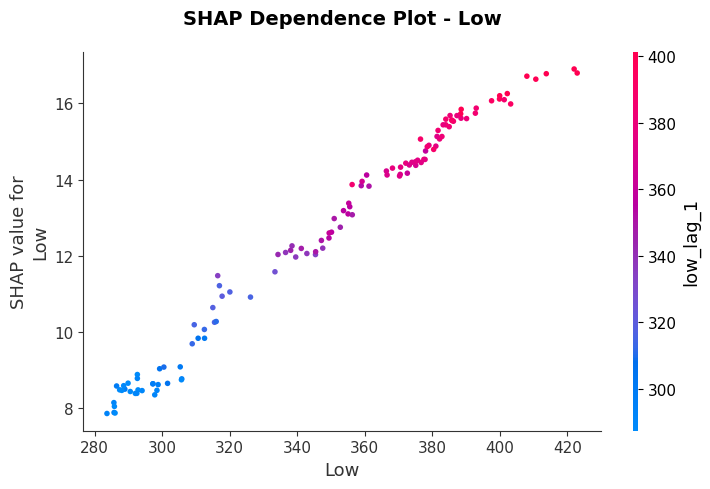


[시각화] SHAP Dependence Plot - Close_Price 생성 중...
✅ 저장 완료: shap_results_rf/dependence_Close_Price.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

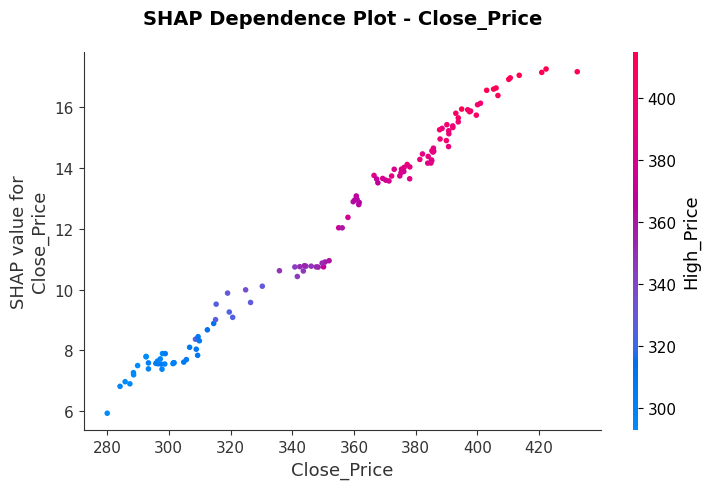


[시각화] SHAP Dependence Plot - close_lag_1 생성 중...
✅ 저장 완료: shap_results_rf/dependence_close_lag_1.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

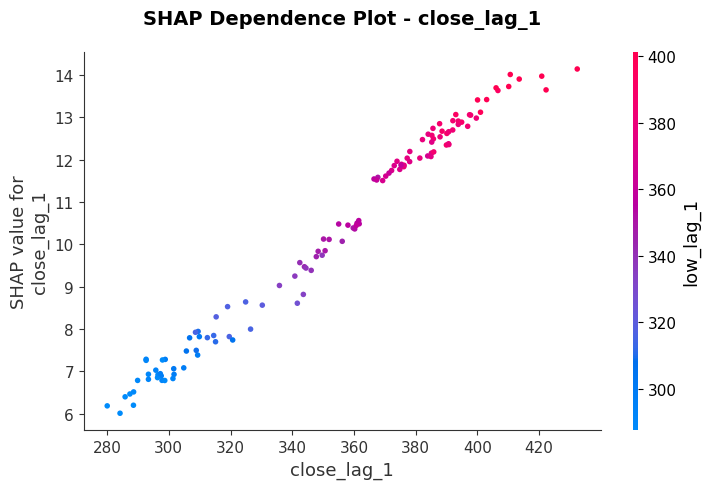


[분석 3] 개별 예측 분석
--------------------------------------------------------------------------------

[시각화] SHAP Waterfall Plot (Sample 0) 생성 중...
✅ 저장 완료: shap_results_rf/waterfall_sample_0.png


<Figure size 640x480 with 0 Axes>

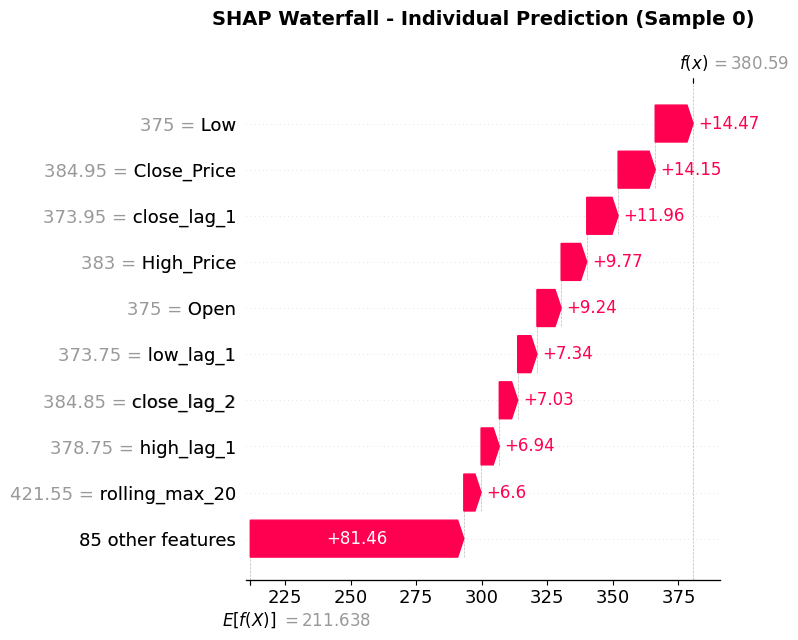


[개별 예측 분석] Sample 0
--------------------------------------------------------------------------------

Base Value (평균 예측): 211.6382
예측값: 380.5903

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 375.0000 | SHAP: +14.4696
↑ Close_Price                    | 값: 384.9500 | SHAP: +14.1503
↑ close_lag_1                    | 값: 373.9500 | SHAP: +11.9635
↑ High_Price                     | 값: 383.0000 | SHAP:  +9.7685
↑ Open                           | 값: 375.0000 | SHAP:  +9.2368
↑ low_lag_1                      | 값: 373.7500 | SHAP:  +7.3390
↑ close_lag_2                    | 값: 384.8500 | SHAP:  +7.0263
↑ high_lag_1                     | 값: 378.7500 | SHAP:  +6.9420
↑ rolling_max_20                 | 값: 421.5500 | SHAP:  +6.5971
↑ sma_50                         | 값: 385.8820 | SHAP:  +6.2559

[시각화] SHAP Waterfall Plot (Sample 10) 생성 중...
✅ 저장 완료: shap_results_rf/waterfall_sample_10.png


<Figure size 640x480 with 0 Axes>

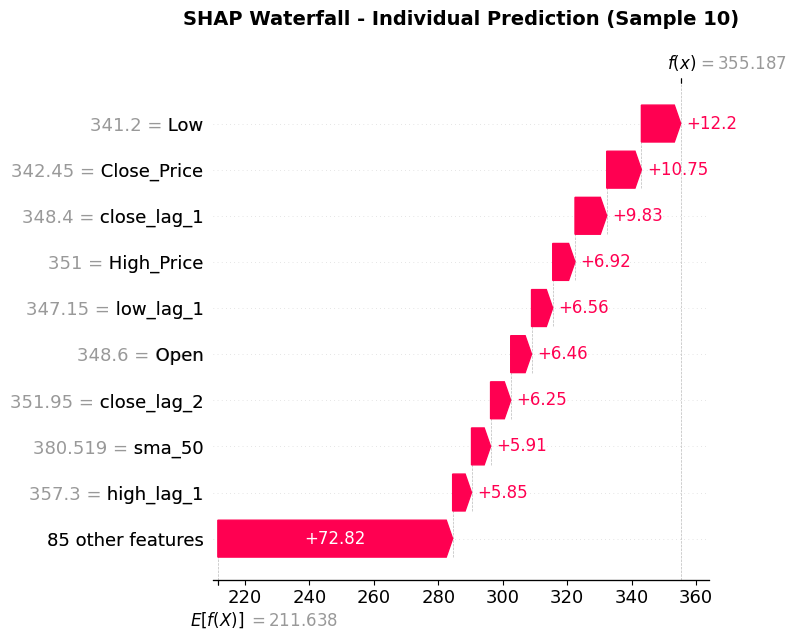


[개별 예측 분석] Sample 10
--------------------------------------------------------------------------------

Base Value (평균 예측): 211.6382
예측값: 355.1867

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 341.2000 | SHAP: +12.1954
↑ Close_Price                    | 값: 342.4500 | SHAP: +10.7495
↑ close_lag_1                    | 값: 348.4000 | SHAP:  +9.8350
↑ High_Price                     | 값: 351.0000 | SHAP:  +6.9176
↑ low_lag_1                      | 값: 347.1500 | SHAP:  +6.5633
↑ Open                           | 값: 348.6000 | SHAP:  +6.4627
↑ close_lag_2                    | 값: 351.9500 | SHAP:  +6.2455
↑ sma_50                         | 값: 380.5190 | SHAP:  +5.9081
↑ high_lag_1                     | 값: 357.3000 | SHAP:  +5.8525
↑ rolling_max_20                 | 값: 401.1000 | SHAP:  +5.7064

[시각화] SHAP Waterfall Plot (Sample 20) 생성 중...
✅ 저장 완료: shap_results_rf/waterfall_sample_20.png


<Figure size 640x480 with 0 Axes>

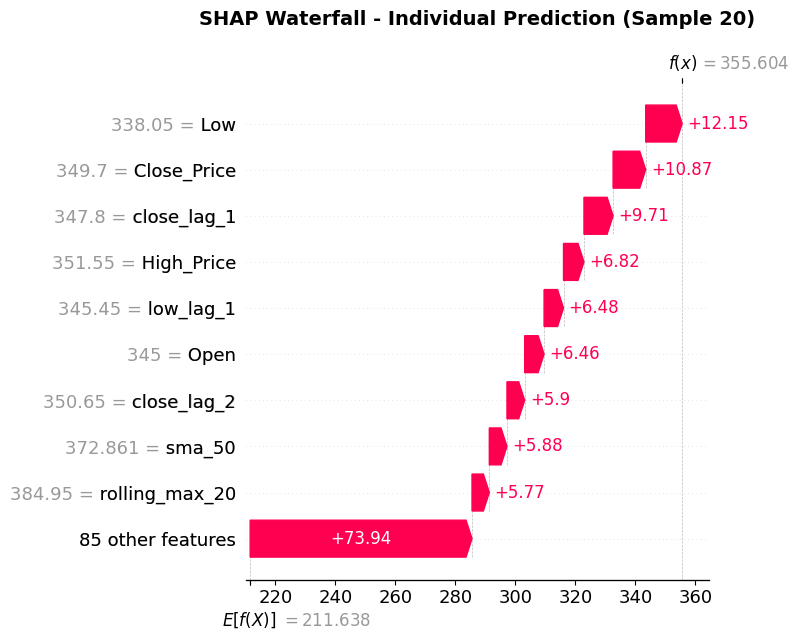


[개별 예측 분석] Sample 20
--------------------------------------------------------------------------------

Base Value (평균 예측): 211.6382
예측값: 355.6045

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 338.0500 | SHAP: +12.1455
↑ Close_Price                    | 값: 349.7000 | SHAP: +10.8676
↑ close_lag_1                    | 값: 347.8000 | SHAP:  +9.7093
↑ High_Price                     | 값: 351.5500 | SHAP:  +6.8157
↑ low_lag_1                      | 값: 345.4500 | SHAP:  +6.4773
↑ Open                           | 값: 345.0000 | SHAP:  +6.4650
↑ close_lag_2                    | 값: 350.6500 | SHAP:  +5.9033
↑ sma_50                         | 값: 372.8610 | SHAP:  +5.8784
↑ rolling_max_20                 | 값: 384.9500 | SHAP:  +5.7690
↑ high_lag_1                     | 값: 352.0000 | SHAP:  +5.5298

[시각화] SHAP Waterfall Plot (Sample 50) 생성 중...
✅ 저장 완료: shap_results_rf/waterfall_sample_50.png


<Figure size 640x480 with 0 Axes>

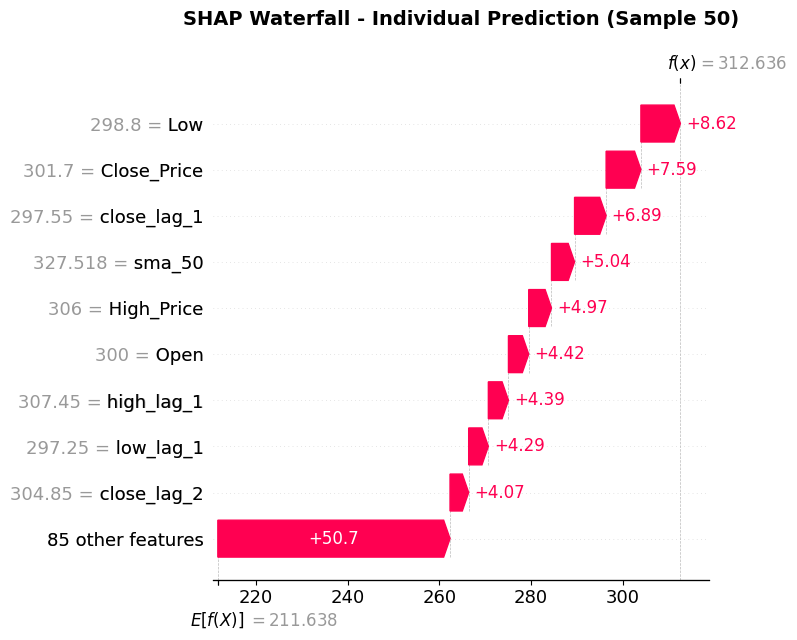


[개별 예측 분석] Sample 50
--------------------------------------------------------------------------------

Base Value (평균 예측): 211.6382
예측값: 312.6360

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 298.8000 | SHAP:  +8.6236
↑ Close_Price                    | 값: 301.7000 | SHAP:  +7.5935
↑ close_lag_1                    | 값: 297.5500 | SHAP:  +6.8913
↑ sma_50                         | 값: 327.5180 | SHAP:  +5.0381
↑ High_Price                     | 값: 306.0000 | SHAP:  +4.9743
↑ Open                           | 값: 300.0000 | SHAP:  +4.4235
↑ high_lag_1                     | 값: 307.4500 | SHAP:  +4.3894
↑ low_lag_1                      | 값: 297.2500 | SHAP:  +4.2932
↑ close_lag_2                    | 값: 304.8500 | SHAP:  +4.0724
↑ rolling_max_20                 | 값: 314.5500 | SHAP:  +4.0275

[시각화] SHAP Waterfall Plot (Sample 100) 생성 중...
✅ 저장 완료: shap_results_rf/waterfall_sample_100.png


<Figure size 640x480 with 0 Axes>

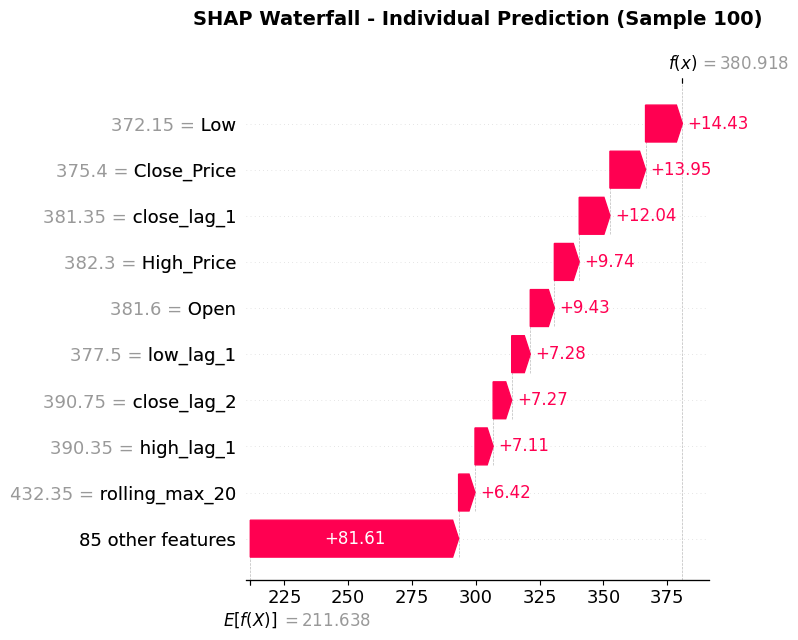


[개별 예측 분석] Sample 100
--------------------------------------------------------------------------------

Base Value (평균 예측): 211.6382
예측값: 380.9178

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 372.1500 | SHAP: +14.4313
↑ Close_Price                    | 값: 375.4000 | SHAP: +13.9510
↑ close_lag_1                    | 값: 381.3500 | SHAP: +12.0386
↑ High_Price                     | 값: 382.3000 | SHAP:  +9.7399
↑ Open                           | 값: 381.6000 | SHAP:  +9.4288
↑ low_lag_1                      | 값: 377.5000 | SHAP:  +7.2801
↑ close_lag_2                    | 값: 390.7500 | SHAP:  +7.2655
↑ high_lag_1                     | 값: 390.3500 | SHAP:  +7.1120
↑ rolling_max_20                 | 값: 432.3500 | SHAP:  +6.4184
↑ sma_50                         | 값: 360.2790 | SHAP:  +6.3304

[저장] 분석 결과 저장 중...
✅ 모든 결과가 'shap_results_rf' 디렉토리에 저장되었습니다!

✅ 분석 완료!
예제 2: Multi-step Direct 모델 SHAP 분석 (Li

<Figure size 640x480 with 0 Axes>

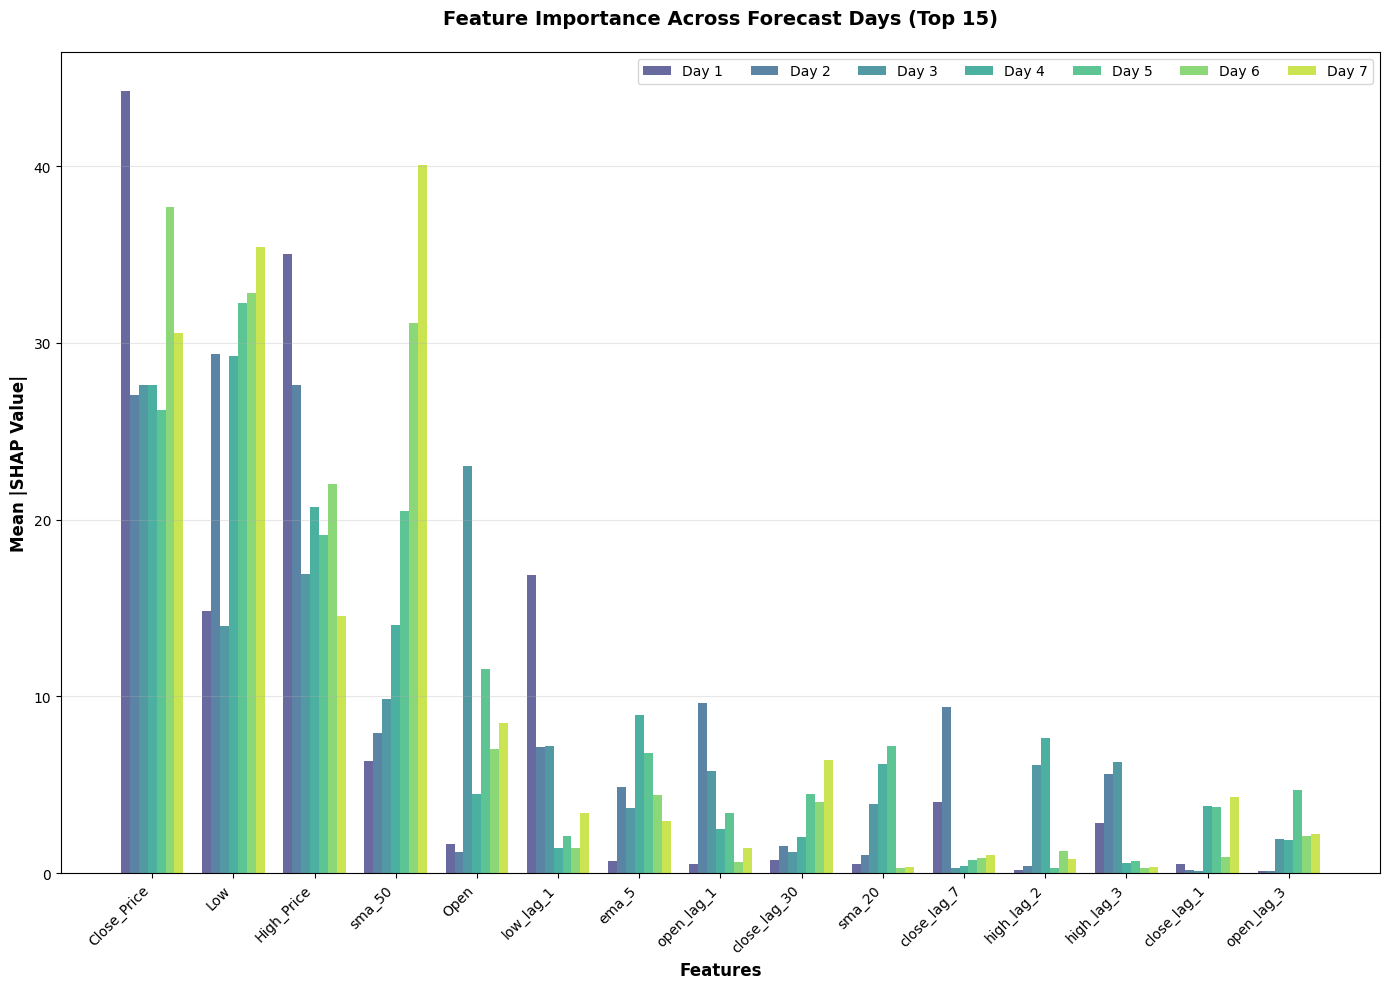


예측일별 Feature Importance (Top 10):
                   Day1       Day2       Day3       Day4       Day5       Day6       Day7
Close_Price   44.255059  27.024613  27.595790  27.624481  26.213406  37.677958  30.534613
Low           14.822692  29.354820  13.990718  29.244037  32.276247  32.833386  35.428288
High_Price    35.044933  27.619457  16.902096  20.713389  19.146137  22.042760  14.520260
sma_50         6.327731   7.925652   9.824820  14.039220  20.487035  31.139460  40.043432
Open           1.621162   1.192371  23.023889   4.477599  11.577312   7.042644   8.517394
low_lag_1     16.880419   7.154691   7.164966   1.420435   2.074313   1.438479   3.411014
ema_5          0.659505   4.854226   3.659881   8.922236   6.816183   4.428485   2.955544
open_lag_1     0.514530   9.653160   5.787720   2.485303   3.417868   0.633949   1.444053
close_lag_30   0.735149   1.515407   1.206951   2.030667   4.496854   4.016043   6.376236
sma_20         0.500758   1.004072   3.929630   6.173270   7.1847

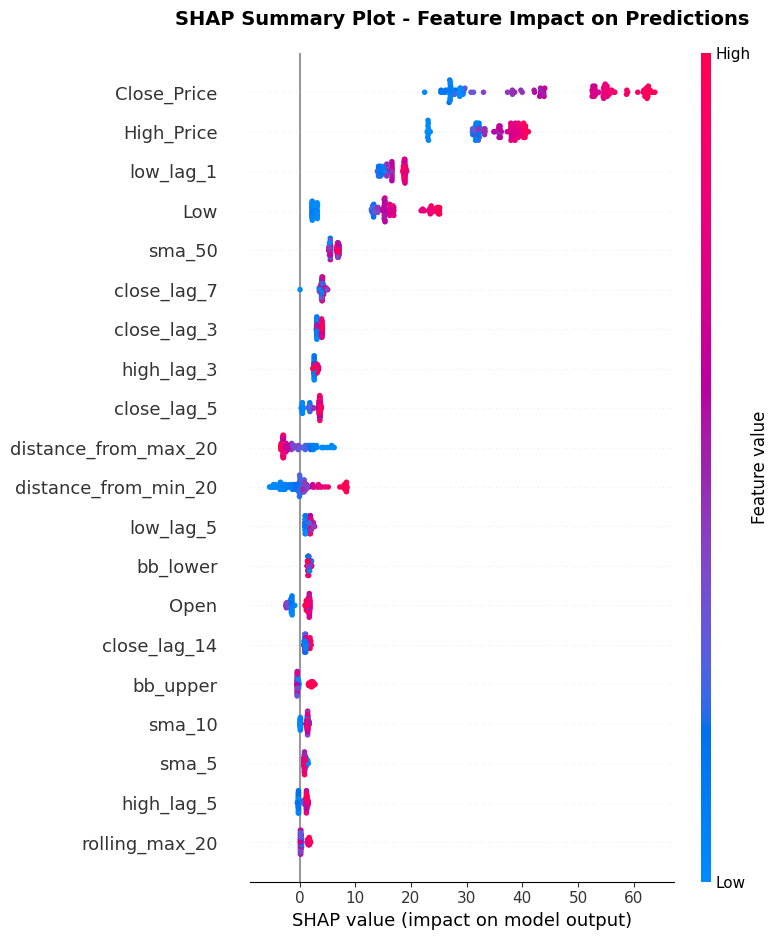


[개별 예측 분석] Sample 0
--------------------------------------------------------------------------------

Base Value (평균 예측): 213.3324
예측값: 396.4306

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Close_Price                    | 값: 401.1000 | SHAP: +62.4724
↑ High_Price                     | 값: 404.2000 | SHAP: +40.8563
↑ Low                            | 값: 404.2000 | SHAP: +24.9727
↑ low_lag_1                      | 값: 395.0000 | SHAP: +18.6394
↑ sma_50                         | 값: 385.3720 | SHAP:  +6.9828
↑ close_lag_7                    | 값: 408.2500 | SHAP:  +4.1906
↑ close_lag_3                    | 값: 395.7000 | SHAP:  +3.9513
↑ close_lag_5                    | 값: 412.6500 | SHAP:  +3.6368
↑ high_lag_3                     | 값: 399.9000 | SHAP:  +3.1217
↑ bb_lower                       | 값: 327.4535 | SHAP:  +2.0549

Day 3 상세 분석

[시각화] SHAP Summary Plot 생성 중...
✅ 저장 완료: shap_day3_summary_lgbm.png


<Figure size 640x480 with 0 Axes>

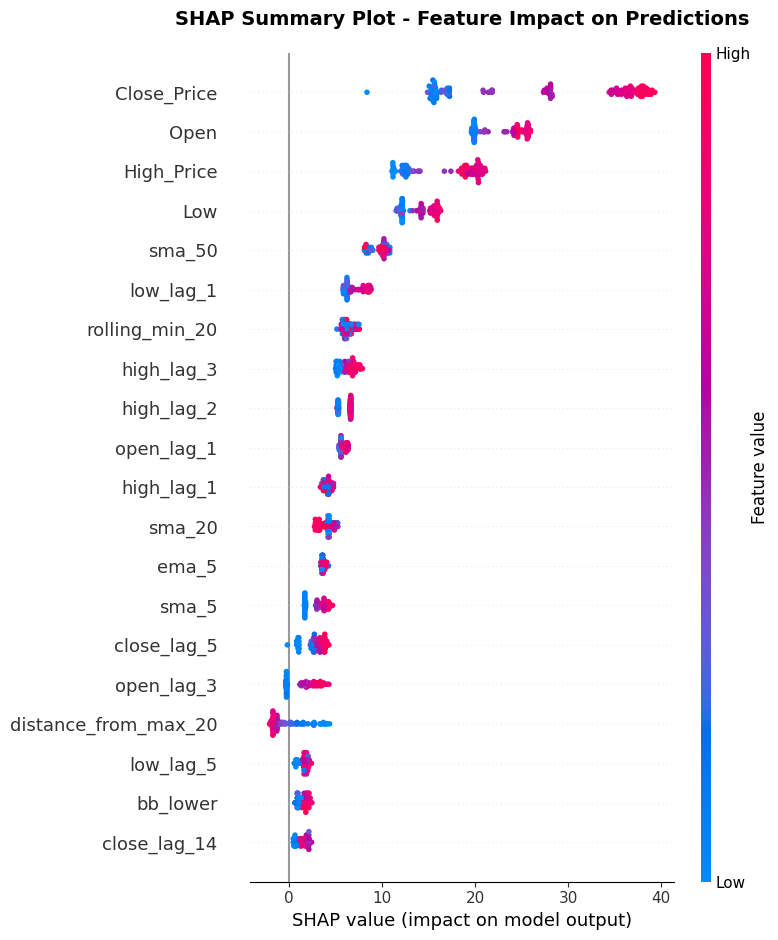


[개별 예측 분석] Sample 0
--------------------------------------------------------------------------------

Base Value (평균 예측): 213.8321
예측값: 389.3764

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Close_Price                    | 값: 401.1000 | SHAP: +38.3840
↑ Open                           | 값: 404.2000 | SHAP: +24.5621
↑ High_Price                     | 값: 404.2000 | SHAP: +19.2469
↑ Low                            | 값: 404.2000 | SHAP: +16.1332
↑ sma_50                         | 값: 385.3720 | SHAP: +10.0891
↑ low_lag_1                      | 값: 395.0000 | SHAP:  +8.5142
↑ high_lag_3                     | 값: 399.9000 | SHAP:  +6.6765
↑ high_lag_2                     | 값: 395.4000 | SHAP:  +6.5902
↑ rolling_min_20                 | 값: 341.7000 | SHAP:  +6.4817
↑ open_lag_1                     | 값: 395.0000 | SHAP:  +5.8955

Day 5 상세 분석

[시각화] SHAP Summary Plot 생성 중...
✅ 저장 완료: shap_day5_summary_lgbm.png


<Figure size 640x480 with 0 Axes>

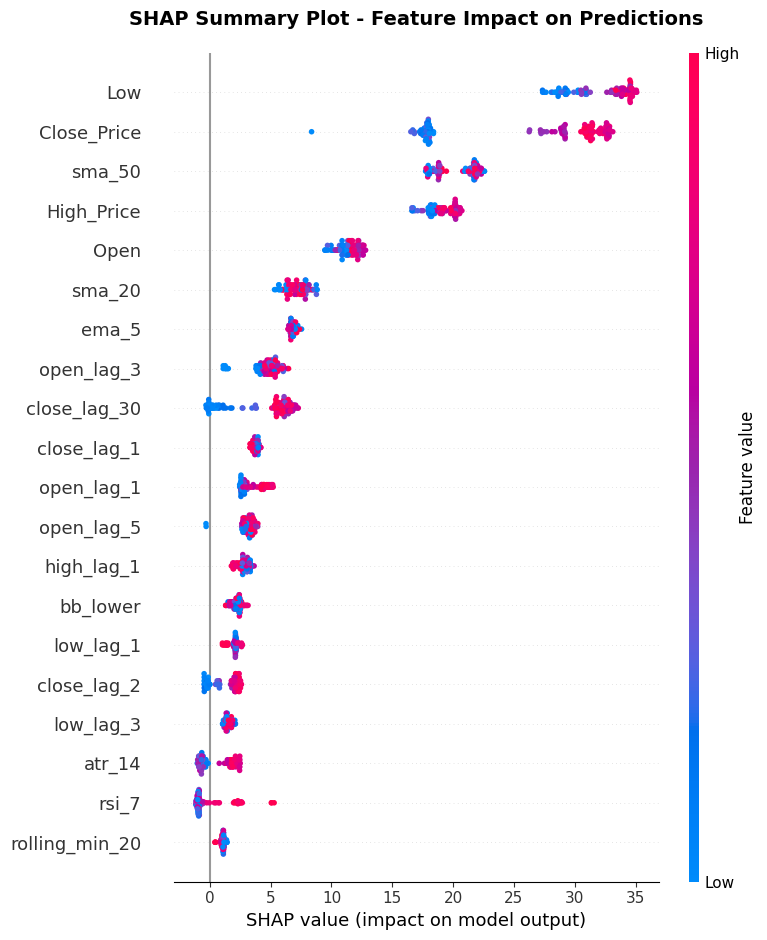


[개별 예측 분석] Sample 0
--------------------------------------------------------------------------------

Base Value (평균 예측): 214.2958
예측값: 386.3151

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ Low                            | 값: 404.2000 | SHAP: +34.5820
↑ Close_Price                    | 값: 401.1000 | SHAP: +31.5532
↑ sma_50                         | 값: 385.3720 | SHAP: +21.8501
↑ High_Price                     | 값: 404.2000 | SHAP: +20.1770
↑ Open                           | 값: 404.2000 | SHAP: +11.9962
↑ sma_20                         | 값: 380.1125 | SHAP:  +7.4063
↑ ema_5                          | 값: 400.6639 | SHAP:  +7.3479
↑ close_lag_30                   | 값: 393.4000 | SHAP:  +6.4483
↑ open_lag_3                     | 값: 399.9000 | SHAP:  +5.0690
↑ open_lag_1                     | 값: 395.0000 | SHAP:  +4.4805

Day 7 상세 분석

[시각화] SHAP Summary Plot 생성 중...
✅ 저장 완료: shap_day7_summary_lgbm.png


<Figure size 640x480 with 0 Axes>

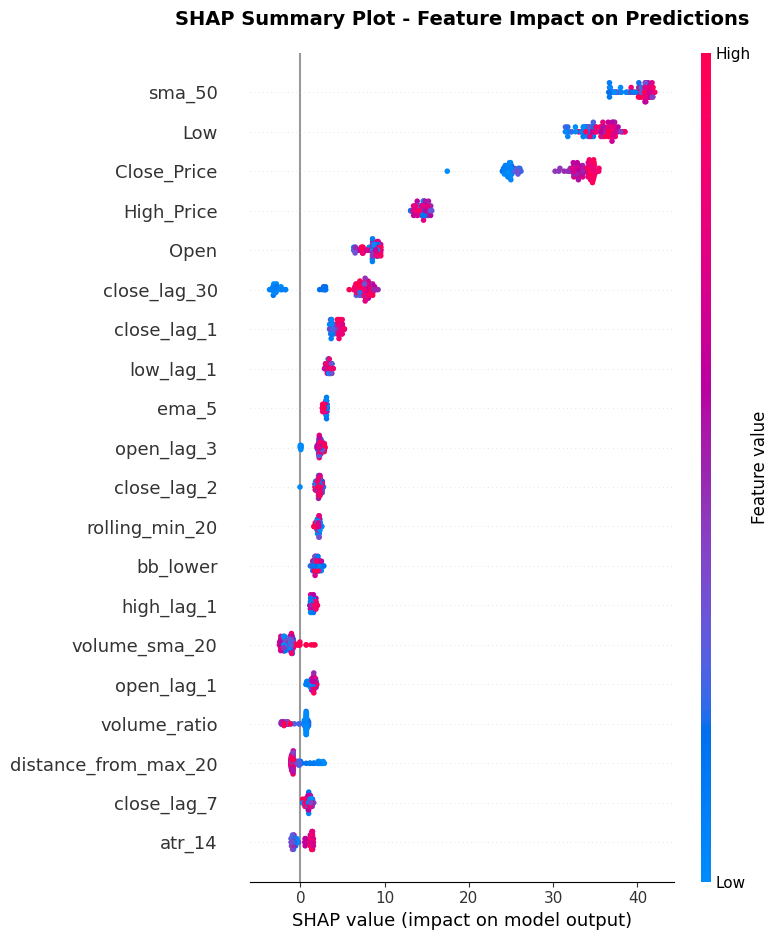


[개별 예측 분석] Sample 0
--------------------------------------------------------------------------------

Base Value (평균 예측): 214.8443
예측값: 380.9755

Top 10 Feature 기여도:
--------------------------------------------------------------------------------
↑ sma_50                         | 값: 385.3720 | SHAP: +40.4266
↑ Low                            | 값: 404.2000 | SHAP: +36.7766
↑ Close_Price                    | 값: 401.1000 | SHAP: +34.6452
↑ High_Price                     | 값: 404.2000 | SHAP: +14.6926
↑ Open                           | 값: 404.2000 | SHAP:  +9.5166
↑ close_lag_30                   | 값: 393.4000 | SHAP:  +6.5991
↑ close_lag_1                    | 값: 398.9500 | SHAP:  +4.6604
↑ low_lag_1                      | 값: 395.0000 | SHAP:  +3.4465
↑ open_lag_3                     | 값: 399.9000 | SHAP:  +2.8485
↑ ema_5                          | 값: 400.6639 | SHAP:  +2.8003

✅ Multi-step Direct LightGBM 모델 SHAP 분석 완료!

💡 SHAP 분석 핵심 요약

# 1. SHAP은 각 feature가 예측에 미치는 실제 기여도를 정확하게 측정
# 2

In [7]:
"""
SHAP Analysis for Random Forest and LightGBM Models - Complete Implementation
실행 가능한 완전한 코드: 커피 선물 가격 예측 모델 설명

SHAP (SHapley Additive exPlanations) 제공:
- 전역 Feature Importance (어떤 변수가 전반적으로 중요한가?)
- 개별 예측 설명 (왜 이 예측값이 나왔는가?)
- 긍정/부정 영향 방향 (변수가 예측을 올리는가 내리는가?)
- Feature 상호작용 효과
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import shap
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')


# ============================================================================
# Part 1: Multi-step Target 생성 함수 추가
# ============================================================================

def create_direct_multistep_targets(df, forecast_days=7):
    """
    Direct Multi-step을 위한 타겟 변수 생성

    Args:
        df: 원본 데이터프레임 (Close_Price 컬럼 필수)
        forecast_days: 예측할 미래 일수

    Returns:
        타겟 변수가 추가된 데이터프레임
    """
    df = df.copy()

    for day in range(1, forecast_days + 1):
        df[f'target_day{day}'] = df['Close_Price'].shift(-day)

    print(f"✅ Direct Multi-step: {forecast_days}개 타겟 변수 생성 완료")
    print(f"   타겟 컬럼: target_day1 ~ target_day{forecast_days}")

    return df


# ============================================================================
# Part 2: Basic SHAP Analysis Functions
# ============================================================================

def shap_analysis_model(model, X_train, X_test, feature_names, model_type='auto'):
    """
    모델에 대한 SHAP 분석 수행 (RandomForest, XGBoost, 또는 LightGBM)

    Args:
        model: 학습된 모델
        X_train: 학습 데이터 (배경 데이터로 사용)
        X_test: 테스트 데이터
        feature_names: Feature 이름 리스트
        model_type: 'randomforest', 'xgboost', 'lightgbm', 또는 'auto'

    Returns:
        shap_values: SHAP 값
        explainer: SHAP explainer 객체
    """
    print("\n" + "="*80)
    print(f"SHAP Analysis - {model_type.upper()}")
    print("="*80)

    print("\n[1] SHAP Explainer 생성 중...")

    # TreeExplainer 사용 (트리 기반 모델에 최적화)
    if model_type in ['randomforest', 'auto']:
        # RandomForest의 경우 배경 데이터 샘플링
        background = shap.sample(X_train, min(100, len(X_train)))
        explainer = shap.TreeExplainer(model, background)
    elif model_type in ['lightgbm']:
        # LightGBM은 feature_perturbation='tree_path_dependent' 사용하여 호환성 개선
        try:
            explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
        except Exception as e:
            print(f"   ⚠️ TreeExplainer 초기화 실패, 대안 방법 시도...")
            # 대안: 배경 데이터를 사용하여 초기화
            background = shap.sample(X_train, min(100, len(X_train)))
            explainer = shap.TreeExplainer(model, background, feature_perturbation='tree_path_dependent')
    else:  # xgboost
        # XGBoost는 feature_perturbation='tree_path_dependent' 사용하여 호환성 개선
        try:
            explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
        except Exception as e:
            print(f"   ⚠️ TreeExplainer 초기화 실패, 대안 방법 시도...")
            # 대안: 배경 데이터를 사용하여 초기화
            background = shap.sample(X_train, min(100, len(X_train)))
            explainer = shap.TreeExplainer(model, background, feature_perturbation='tree_path_dependent')

    print("[2] SHAP 값 계산 중...")
    print(f"   테스트 샘플 수: {len(X_test)}")

    # SHAP 값 계산
    shap_values = explainer.shap_values(X_test)

    print(f"✅ SHAP 값 계산 완료!")
    print(f"   Shape: {shap_values.shape}")

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_val = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        expected_val = explainer.expected_value

    print(f"   Base value (평균 예측): {expected_val:.4f}")

    return shap_values, explainer


# ============================================================================
# Part 3: Visualization Functions
# ============================================================================

def plot_shap_summary(shap_values, X_test, feature_names, save_path=None):
    """
    SHAP Summary Plot: 전역 Feature Importance + 방향성
    가장 중요한 시각화! 각 feature의 영향도와 방향을 한눈에 파악
    """
    print("\n[시각화] SHAP Summary Plot 생성 중...")

    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test,
                     feature_names=feature_names,
                     plot_type="dot",
                     show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()

def plot_shap_bar(shap_values, X_test, feature_names, top_n=20, save_path=None):
    """
    SHAP Bar Plot: 평균 절대 SHAP 값 (전역 중요도)
    Feature Importance보다 더 정확한 중요도 측정
    """
    print(f"\n[시각화] SHAP Bar Plot (Top {top_n}) 생성 중...")

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test,
                     feature_names=feature_names,
                     plot_type="bar",
                     max_display=top_n,
                     show=False)
    plt.title(f'Top {top_n} Features by Mean |SHAP Value|',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()

def plot_shap_waterfall(shap_values, explainer, X_test, sample_idx=0,
                        feature_names=None, save_path=None):
    """
    SHAP Waterfall Plot: 개별 예측 설명
    특정 예측이 왜 그렇게 나왔는지 단계별로 설명
    """
    print(f"\n[시각화] SHAP Waterfall Plot (Sample {sample_idx}) 생성 중...")

    # DataFrame인 경우와 array인 경우 모두 처리
    if hasattr(X_test, 'iloc'):
        sample_data = X_test.iloc[sample_idx].values
    else:
        sample_data = X_test[sample_idx]

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        base_value = explainer.expected_value

    # SHAP Explanation 객체 생성
    shap_explanation = shap.Explanation(
        values=shap_values[sample_idx],
        base_values=base_value,
        data=sample_data,
        feature_names=feature_names
    )

    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap_explanation, show=False)
    plt.title(f'SHAP Waterfall - Individual Prediction (Sample {sample_idx})',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()


def plot_shap_dependence(shap_values, X_test, feature_name,
                        feature_names, interaction_feature='auto',
                        save_path=None):
    """
    SHAP Dependence Plot: Feature 값과 SHAP 값의 관계
    특정 feature가 예측에 미치는 영향을 그 값의 범위에 따라 시각화
    """
    print(f"\n[시각화] SHAP Dependence Plot - {feature_name} 생성 중...")

    plt.figure(figsize=(10, 6))

    shap.dependence_plot(
        feature_name,
        shap_values,
        X_test,
        feature_names=feature_names,
        interaction_index=interaction_feature,
        show=False
    )

    plt.title(f'SHAP Dependence Plot - {feature_name}',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()
    return plt.gcf()


# ============================================================================
# Part 4: Analysis Functions
# ============================================================================

def get_global_feature_importance(shap_values, feature_names):
    """
    전역 Feature Importance 계산 (평균 |SHAP 값|)

    Args:
        shap_values: SHAP 값 배열
        feature_names: Feature 이름 리스트

    Returns:
        정렬된 DataFrame (Feature, Importance)
    """
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False)

    return importance_df


def analyze_individual_prediction(shap_values, explainer, X_test,
                                 sample_idx, feature_names, top_n=10):
    """
    개별 예측에 대한 상세 분석

    Args:
        shap_values: SHAP 값
        explainer: SHAP explainer
        X_test: 테스트 데이터
        sample_idx: 분석할 샘플 인덱스
        feature_names: Feature 이름 리스트
        top_n: 출력할 상위 feature 개수
    """
    print(f"\n[개별 예측 분석] Sample {sample_idx}")
    print("-"*80)

    # 해당 샘플의 SHAP 값
    sample_shap = shap_values[sample_idx]

    # DataFrame인 경우와 array인 경우 모두 처리
    if hasattr(X_test, 'iloc'):
        sample_features = X_test.iloc[sample_idx]
    else:
        sample_features = pd.Series(X_test[sample_idx], index=feature_names)

    # expected_value가 배열인 경우 처리
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[0] if len(explainer.expected_value) > 0 else explainer.expected_value
    else:
        base_value = explainer.expected_value

    # SHAP 기여도가 큰 순서대로 정렬
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_value': sample_shap,
        'feature_value': sample_features.values
    })
    shap_importance['abs_shap'] = np.abs(shap_importance['shap_value'])
    shap_importance = shap_importance.sort_values('abs_shap', ascending=False)

    print(f"\nBase Value (평균 예측): {base_value:.4f}")
    print(f"예측값: {base_value + sample_shap.sum():.4f}")
    print(f"\nTop {top_n} Feature 기여도:")
    print("-"*80)

    for idx, row in shap_importance.head(top_n).iterrows():
        direction = "↑" if row['shap_value'] > 0 else "↓"
        print(f"{direction} {row['feature']:30s} | "
              f"값: {row['feature_value']:8.4f} | "
              f"SHAP: {row['shap_value']:+8.4f}")

    return shap_importance


# ============================================================================
# Part 5: Complete Analysis Pipeline
# ============================================================================

def complete_shap_analysis(model, X_train, X_test, feature_names,
                          model_type='auto', sample_indices=None,
                          output_dir='shap_results'):
    """
    완전한 SHAP 분석 파이프라인
    모든 시각화와 분석을 한번에 수행

    Args:
        model: 학습된 모델
        X_train: 학습 데이터
        X_test: 테스트 데이터
        feature_names: Feature 이름 리스트
        model_type: 'randomforest', 'xgboost', 'lightgbm', 또는 'auto'
        sample_indices: 개별 분석할 샘플 인덱스 리스트
        output_dir: 결과 저장 디렉토리

    Returns:
        dict: 모든 분석 결과
    """
    print("\n" + "="*80)
    print("완전한 SHAP 분석 파이프라인")
    print("="*80)

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # ========================================================================
    # 1. SHAP 값 계산
    # ========================================================================
    shap_values, explainer = shap_analysis_model(
        model, X_train, X_test, feature_names, model_type
    )

    # ========================================================================
    # 2. 전역 Feature Importance
    # ========================================================================
    print("\n[분석 1] 전역 Feature Importance")
    print("-"*80)
    global_importance = get_global_feature_importance(shap_values, feature_names)
    print("\nTop 20 Features:")
    print(global_importance.head(20).to_string(index=False))

    # ========================================================================
    # 3. 주요 시각화
    # ========================================================================
    print("\n[분석 2] 주요 시각화")
    print("-"*80)

    # Summary Plot (가장 중요!)
    plot_shap_summary(
        shap_values, X_test, feature_names,
        save_path=os.path.join(output_dir, 'summary_plot.png')
    )

    # Bar Plot
    plot_shap_bar(
        shap_values, X_test, feature_names, top_n=20,
        save_path=os.path.join(output_dir, 'bar_plot.png')
    )

    # Dependence Plot (상위 3개 feature)
    for feature in global_importance['feature'].head(3):
        plot_shap_dependence(
            shap_values, X_test, feature, feature_names,
            save_path=os.path.join(output_dir, f'dependence_{feature}.png')
        )

    # ========================================================================
    # 4. 개별 예측 분석
    # ========================================================================
    print("\n[분석 3] 개별 예측 분석")
    print("-"*80)

    if sample_indices is None:
        sample_indices = [0, len(X_test)//2, len(X_test)-1]

    individual_results = {}
    for idx in sample_indices:
        if idx < len(X_test):
            # Waterfall Plot
            plot_shap_waterfall(
                shap_values, explainer, X_test, sample_idx=idx,
                feature_names=feature_names,
                save_path=os.path.join(output_dir, f'waterfall_sample_{idx}.png')
            )

            # 상세 분석
            individual_results[idx] = analyze_individual_prediction(
                shap_values, explainer, X_test, idx, feature_names, top_n=10
            )

    # ========================================================================
    # 5. 결과 저장
    # ========================================================================
    print("\n[저장] 분석 결과 저장 중...")

    # Global importance 저장
    global_importance.to_csv(
        os.path.join(output_dir, 'global_importance.csv'),
        index=False
    )

    print(f"✅ 모든 결과가 '{output_dir}' 디렉토리에 저장되었습니다!")

    return {
        'shap_values': shap_values,
        'explainer': explainer,
        'global_importance': global_importance,
        'individual_results': individual_results
    }


# ============================================================================
# Part 6: Multi-step Direct 모델 SHAP 분석
# ============================================================================

def shap_analysis_multistep_direct(models_dict, X_train, X_test, feature_names):
    """
    Direct Multi-step 모델들의 SHAP 분석
    각 예측일별로 독립적인 SHAP 분석 수행

    Args:
        models_dict: {day: model} 딕셔너리 (day=1,2,...,7)
        X_train: 학습 데이터
        X_test: 테스트 데이터
        feature_names: Feature 이름 리스트

    Returns:
        shap_values_dict: {day: shap_values} 딕셔너리
        explainers_dict: {day: explainer} 딕셔너리
    """
    print("\n" + "="*80)
    print("Direct Multi-step 모델 SHAP 분석")
    print("="*80)

    shap_values_dict = {}
    explainers_dict = {}

    for day, model in models_dict.items():
        print(f"\n[Day {day}] SHAP 분석 중...")
        print("-"*60)

        shap_values, explainer = shap_analysis_model(
            model=model,
            X_train=X_train,
            X_test=X_test,
            feature_names=feature_names,
            model_type='lightgbm'  # ← LightGBM으로 변경
        )

        shap_values_dict[day] = shap_values
        explainers_dict[day] = explainer

    print("\n✅ 모든 예측일에 대한 SHAP 분석 완료!")

    return shap_values_dict, explainers_dict


def plot_shap_comparison_across_days(shap_values_dict, feature_names,
                                     top_n=15, save_path=None):
    """
    예측일별 Feature Importance 비교

    Args:
        shap_values_dict: {day: shap_values} 딕셔너리
        feature_names: Feature 이름 리스트
        top_n: 출력할 상위 feature 개수
        save_path: 저장 경로

    Returns:
        fig: matplotlib Figure
        importance_df: Feature Importance 비교 DataFrame
    """
    print("\n[시각화] 예측일별 Feature Importance 비교")
    print("-"*80)

    # 각 날짜별 importance 계산
    importance_data = {}
    for day, shap_values in shap_values_dict.items():
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        importance_data[f'Day{day}'] = mean_abs_shap

    # DataFrame 생성
    importance_df = pd.DataFrame(importance_data, index=feature_names)

    # 평균 importance 기준으로 상위 feature 선택
    importance_df['mean'] = importance_df.mean(axis=1)
    top_features = importance_df.nlargest(top_n, 'mean').drop('mean', axis=1)

    # 시각화
    fig, ax = plt.subplots(figsize=(14, 10))

    x = np.arange(len(top_features))
    width = 0.11  # 7개 bar를 위한 너비

    colors = plt.cm.viridis(np.linspace(0.2, 0.9, 7))

    for i, day in enumerate(range(1, 8)):
        offset = (i - 3) * width
        ax.bar(x + offset, top_features[f'Day{day}'],
               width, label=f'Day {day}', color=colors[i], alpha=0.8)

    ax.set_xlabel('Features', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance Across Forecast Days (Top {top_n})',
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(top_features.index, rotation=45, ha='right')
    ax.legend(ncol=7, loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 저장 완료: {save_path}")

    plt.show()

    # 결과 출력
    print("\n예측일별 Feature Importance (Top 10):")
    print("="*80)
    importance_summary = importance_df.nlargest(10, 'mean').drop('mean', axis=1)
    print(importance_summary.to_string())

    return fig, importance_df


# ============================================================================
# Part 7: 예제 코드
# ============================================================================

def main_example_single_model():
    """
    예제 1: 단일 모델(RandomForest)에 대한 전체 SHAP 분석
    """
    print("="*80)
    print("예제 1: 단일 RandomForest 모델 SHAP 분석")
    print("="*80)

    # ========================================================================
    # 1. 데이터 준비 (실제 사용시에는 df_with_features를 로드)
    # ========================================================================
    print("\n[1단계] 데이터 로드")
    print("-"*80)

    # 여기서는 이미 feature engineering이 완료된 df_with_features가 있다고 가정
    # df_with_features는 이미 존재하는 변수여야 함

    # ========================================================================
    # 2. Feature와 Target 분리
    # ========================================================================
    print("\n[2단계] Feature와 Target 분리")
    print("-"*80)

    # 제외할 컬럼
    #original_cols = ['Date', 'Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    original_cols = ['Date', 'target_next_close']


    # Feature 컬럼 선택
    feature_cols = [col for col in df_with_features.columns
                   if col not in original_cols]

    X = df_with_features[feature_cols]
    y = df_with_features['Close_Price']

    # 데이터 타입 정리
    X = X.select_dtypes(include=[np.number])
    X = X.astype(np.float64)
    X = X.replace([np.inf, -np.inf], 0)
    X = X.fillna(0)

    print(f"✅ Feature 개수: {X.shape[1]}")
    print(f"✅ 샘플 개수: {len(X)}")

    # Train/Test Split (시계열 순서 유지)
    train_size = int(len(X) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    feature_names = X.columns.tolist()

    print(f"✅ Train: {len(X_train)}행")
    print(f"✅ Test: {len(X_test)}행")

    # ========================================================================
    # 3. 모델 학습
    # ========================================================================
    print("\n[3단계] RandomForest 모델 학습")
    print("-"*80)

    rf_model = RandomForestRegressor(
        n_estimators=400,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    rf_model.fit(X_train, y_train)

    # 성능 평가
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"✅ 모델 학습 완료!")
    print(f"   MAE: ${mae:.4f}")
    print(f"   RMSE: ${rmse:.4f}")
    print(f"   R²: {r2:.4f}")


    # ========================================================================
    # 4. SHAP 분석
    # ========================================================================
    print("\n[4단계] SHAP 분석")
    print("-"*80)

    # SHAP 분석 실행

    results = complete_shap_analysis(
        model=rf_model,
        X_train=X_train,
        X_test=X_test,
        feature_names=feature_names,
        model_type='randomforest',
        sample_indices=[0, 10, 20, 50, 100],
        output_dir='shap_results_rf'
    )

    # 결과 활용
    shap_values = results['shap_values']
    global_importance = results['global_importance']

    print("\n" + "="*80)
    print("✅ 분석 완료!")
    print("="*80)



def main_example_multistep():
    """
    예제 2: Multi-step Direct 모델들에 대한 SHAP 분석
    multi_step_forecasting.txt의 코드를 참고하여 수정됨
    LightGBM 모델 사용으로 변경됨
    """
    print("="*80)
    print("예제 2: Multi-step Direct 모델 SHAP 분석 (LightGBM)")
    print("="*80)

    # ========================================================================
    # 1. 데이터 로드 및 준비
    # ========================================================================
    print("\n[1단계] 데이터 로드 및 Feature Engineering")
    print("-"*80)

    # 여기서는 이미 feature engineering이 완료된 df_with_features가 있다고 가정
    # df_with_features는 이미 존재하는 변수여야 함

    # ========================================================================
    # 2. Multi-step 타겟 생성
    # ========================================================================
    print("\n[2단계] Multi-step 타겟 생성")
    print("-"*80)

    df_multistep = create_direct_multistep_targets(df_with_features, forecast_days=7)
    df_clean = df_multistep.dropna()
    print(f"✅ 유효 데이터: {len(df_clean)}행")

    # ========================================================================
    # 3. Feature와 Target 분리
    # ========================================================================
    print("\n[3단계] Feature와 Target 분리")
    print("-"*80)

    #original_cols = ['Date', 'Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    original_cols = ['Date', 'target_next_close']
    target_cols = [f'target_day{i}' for i in range(1, 8)]
    feature_cols = [col for col in df_clean.columns
                   if col not in original_cols + target_cols]

    X = df_clean[feature_cols]
    print(X.columns)

    # 데이터 타입 정리
    X = X.select_dtypes(include=[np.number])
    X = X.astype(np.float64)
    X = X.replace([np.inf, -np.inf], 0)
    X = X.fillna(0)

    print(f"\n✅ Feature 개수: {X.shape[1]}")
    print(f"✅ Target 개수: {len(target_cols)}")

    # Train/Test Split (시계열 순서 유지)
    train_size = int(len(df_clean) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]

    feature_names = X.columns.tolist()

    print(f"✅ Train: {len(X_train)}행")
    print(f"✅ Test: {len(X_test)}행")
    print(f"✅ Features: {len(feature_cols)}개")

    # ========================================================================
    # 4. Direct Multi-step LightGBM 모델 학습
    # ========================================================================
    print("\n[4단계] Direct Multi-step LightGBM 모델 학습")
    print("-"*80)

    # y_train_dict와 y_test_dict 생성
    y_train_dict = {i: df_clean[f'target_day{i}'].values[:train_size]
                    for i in range(1, 8)}

    y_test_dict = {i: df_clean[f'target_day{i}'].values[train_size:]
                   for i in range(1, 8)}

    # Direct Multi-step 모델 학습
    direct_models = {}

    print("\n각 예측일별 LightGBM 모델 학습:")
    for day in range(1, 8):
        print(f"\n[Day {day}] LightGBM 모델 학습 중...")

        # LightGBM 파라미터 (XGBoost 파라미터를 LightGBM용으로 변환)
        lgbm_params = {
            'n_estimators': 300,
            'max_depth': 15,
            'learning_rate': 0.05,
            'bagging_fraction': 0.8,        # subsample → bagging_fraction
            'feature_fraction': 0.8,        # colsample_bytree → feature_fraction
            'min_child_samples': 20,        # min_child_weight → min_child_samples (정수)
            'min_split_gain': 0.1,          # gamma → min_split_gain
            'reg_alpha': 0.1,
            'reg_lambda': 1.5,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1,                # verbosity 0 → -1 (silent)
            'bagging_freq': 1               # bagging을 활성화하기 위해 필요
        }

        # LightGBM 모델 생성 및 학습
        model = LGBMRegressor(**lgbm_params)
        model.fit(X_train, y_train_dict[day])
        direct_models[day] = model

        # 예측 및 평가
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test_dict[day], pred)
        rmse = np.sqrt(mean_squared_error(y_test_dict[day], pred))
        r2 = r2_score(y_test_dict[day], pred)

        print(f"   MAE: ${mae:.2f}, RMSE: ${rmse:.2f}, R²: {r2:.4f}")

    print("\n✅ 7개의 Direct LightGBM 모델 학습 완료!")
    print(f"   direct_models = {{1: model_day1, 2: model_day2, ..., 7: model_day7}}")

    # ========================================================================
    # 5. SHAP 분석
    # ========================================================================
    print("\n[5단계] SHAP 분석")
    print("-"*80)

    # SHAP analysis
    shap_values_dict, explainers_dict = shap_analysis_multistep_direct(
        models_dict=direct_models,
        X_train=X_train,
        X_test=X_test,
        feature_names=feature_names
    )

    # 예측일별 비교
    fig, importance_df = plot_shap_comparison_across_days(
        shap_values_dict,
        feature_names,
        top_n=15,
        save_path='shap_multistep_direct_comparison_lgbm.png'
    )

    # 각 날짜별 상세 분석
    for day in [1, 3, 5, 7]:  # 대표 날짜만
        print(f"\n{'='*80}")
        print(f"Day {day} 상세 분석")
        print('='*80)

        # Summary plot
        plot_shap_summary(
            shap_values_dict[day],
            X_test,
            feature_names,
            save_path=f'shap_day{day}_summary_lgbm.png'
        )

        # 개별 예측 설명
        analyze_individual_prediction(
            shap_values_dict[day],
            explainers_dict[day],
            X_test,
            sample_idx=0,
            feature_names=feature_names,
            top_n=10
        )

    print("\n" + "="*80)
    print("✅ Multi-step Direct LightGBM 모델 SHAP 분석 완료!")
    print("="*80)


# ============================================================================
# Main
# ============================================================================

if __name__ == "__main__":
    print("\n")
    print("="*80)
    print("SHAP Analysis - 실행 가능한 완전한 코드 (LightGBM 버전)")
    print("="*80)
    print("\n이 코드는 두 가지 예제를 제공합니다:")
    print("1. main_example_single_model(): 단일 모델 SHAP 분석")
    print("2. main_example_multistep(): Multi-step Direct LightGBM 모델 SHAP 분석")
    print("\n실행 방법:")
    print("1. 데이터를 로드하고 feature engineering 수행")
    print("2. 모델을 학습")
    print("3. 각 함수의 주석을 해제하고 실행")
    print("\n" + "="*80)

    # 예제 실행 (주석 해제하여 사용)
    main_example_single_model()
    main_example_multistep()

    print("\n" + "="*80)
    print("💡 SHAP 분석 핵심 요약")
    print("="*80)

    print("""
# 1. SHAP은 각 feature가 예측에 미치는 실제 기여도를 정확하게 측정
# 2. Summary Plot: 가장 중요한 시각화 - 전역 중요도 + 방향성
# 3. Waterfall Plot: 개별 예측 설명 - "왜 이 값이 나왔나?"
# 4. Dependence Plot: Feature 값에 따른 영향도 변화
# 5. SHAP > Traditional Feature Importance (더 정확함)

# 주요 함수:
# - complete_shap_analysis(): 모든 분석을 한번에
# - shap_analysis_multistep_direct(): Multi-step 모델 분석

# 변경 사항:
# - XGBoost → LightGBM으로 변경
# - 파라미터 매핑: subsample→bagging_fraction, colsample_bytree→feature_fraction
# - base_score 파라미터 제거 (LightGBM에서 지원하지 않음)
""")